## (B)  Build a minimal generative model and use it to analyze test data

### 1. Import your package in the documentation notebook.

In [23]:
import lennardjones

### 2. Describe your generative model.

#### We will start with just the Lennard Jones model.

The Lennard Jones *potential* has a well known phenominolgical model:

$$ U_\text{LJ} = 4 \epsilon \left ( \frac{\sigma_\text{LJ}^{12}}{z^{12}} - \frac{\sigma_\text{LJ}^6}{z^6} \right ) $$

Where $\epsilon$ is the depth of the well (or 'strength' of the interaction), $\sigma$ is distance when the potential is 0 (or the 'size' of the interacting particles), and $z$ is the distance between the particles.

To compute the force, $F = -\partial U / \partial z$, so 
$$ F_\text{LJ} = 4 \epsilon \left ( \frac{12\sigma_\text{LJ}^{12}}{z^{13}} - \frac{6\sigma_\text{LJ}^6}{z^7} \right ) $$

The goal of the first task is to fit to the above model, using $\epsilon$ and $\sigma$ as parameters. 

However, the measured data is frequency shift (df) and must be first coverted to force. This is done using the Sader-Jarvis method, which takes an intergral over the distance data, starting at the closest $z$ position. 

All parameters in the Sader-Jarvis formula are known experimental parameters. 

## Change $1/z^6$ term to a more realistic vdW term

M3 in the proposal

$$ F_\text{3}(z:H,R, \theta, z_\text{off}) = - \frac{H}{6} \left( \frac{R}{\hat{z}^2} + \frac{R(1-\sin\theta)}{\hat{z}[\hat{z} + R(1-\sin\theta)]} + \frac{\tan^2\theta}{\hat{z} + R(1-\sin\theta)} \right )$$

$$\hat{z} = z - z_\text{off}$$

$z_\text{off}$ is different from $z_0$ based on a sentence from Kuhn and Rahe. However, we can potentially treat them the same (as a first step) and ignore the role of $z_0$ in the force intergral ...

So the full force model looks like, where we will assume no $z_\text{off}$:

$$F = 4\epsilon\frac{12\sigma_\text{LJ}^{12}}{z^{13}} - \frac{H}{6} \left( \frac{R}{z^2} + \frac{R(1-\sin\theta)}{z[z + R(1-\sin\theta)]} + \frac{\tan^2\theta}{z + R(1-\sin\theta)} \right )$$

where parameters are: $\epsilon$, $\sigma_\text{LJ}$, $H$, $R$, and $\theta$. 

$H$ is the Hamaker constant = $\pi^2 C \rho_1 \rho_2$, where $C$ is the London coefficient in the particle–particle pair interaction, and $\rho_1$, $\rho_2$ are the number densities of the two interacting kinds of particles. We should be able to have a reasonable estimate for these things based on parior knowledge of the tip and sample materials.

Similarly, $R$ and $\theta$ are the radius and half-angle opening respectively of the tip geometry which we should be able to set reasonable ranges on.

### Sader-Jarvis method to convert to force

$$ F_\text{meas} = 2k \int_z^\inf \left ( 1 +  \frac{a^{1/2}}{8 \sqrt{\pi(t-z)}} \right ) d\Omega(t) - \frac{a^{3/2}}{\sqrt{2(t-z)}} \frac{d \Omega(t)}{dt} dt $$

where $k$ is the spring constant of the tuning fork, $a$ is the oscillation amplitude, $\Omega(z) = d\omega(z)/ \omega_0 = d\text{f}(z)/\text{f}_0$, and $t$ is the integration variable.

$k$ and $a$ are experiemental details that are known.


#### Experimental considerations

The raw data is frequency shift df and position of the piezo $z'$. 

**df**

The frequency shift is the measured data and has noise. Based on traces taken far from the sample, the background noise on this measurement is $\sigma_\text{df} = 0.5$ Hz. 

***z'***

To keep things simple the first time, we will set the position of the sample $z_0$ equal to 1 nm below the lowest $z'$ position. Thus the tip position relative to the sample (i.e. the $z$ in the above equations) becomes $z$ = $z'$ - ($z_\text{min}$ - 1 nm).

$k$ = 1800 N/m

$a$ = 0.5 nm

In all honesty it is quite possible there is a 10 % uncertainty on each of these parameters as well. It may be desirable to include that as a prior and marginalize out the small range.

However, again to keep things simple in this first itteration, we will assume the values above are exact. 

Given all of this, there are *no* parameters in the force calculation and so we should simple be able to perform the calculation; however, the uncertainty needs to also be converted from df to force (i.e. $\sigma_\text{df} \rightarrow \sigma_\text{force}$ )

##### Use the notation we introduced in the course to describe your statistical model, which should include the priors

I'm a little stuck on this because of the Sader-Jarvis conversion on the y-data. After that however, it would be:

**model**

$\mu = 4 \epsilon \left(\frac{12\sigma^{12}}{z^{13}} - \frac{6\sigma^{6}}{z^{7}} \right )$

**priors**

$\epsilon$ ~ Uniform(0,$\inf$)

$\sigma_\text{LJ}$ ~ Uniform(0,$\inf$)

**Add Gaussian noise to the model**

F ~ normal($\mu$ = $\mu$, $\sigma = \sigma_\text{force}$ )

### 3. Simulate some data using your generative model.

start with LJ force model and work backwards

In [4]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

In [12]:
z = np.arange(2.4, 30, 0.2) #nN

In [13]:
noise = 0.2 #nN

In [14]:
def simulate_data_LJ(epsilon, sigma, z):
    
    perfect_data = 4*epsilon*(12*sigma**12/z**13-6*sigma**6/z**7)
    
    #add some noise
    data = perfect_data + scipy.stats.norm.rvs(loc=0, scale = noise, size = len(z))
    
    #I know this will create something ~ nN
    return data

In [8]:
def simulate_data_M3(epsilon, sigma, H, R, theta, z):
    
    theta_rad = np.deg2rad(theta)
    
    perfect_data = 4*epsilon*(12*sigma**12/z**13) - H/6*(R/z**2 
                                                         + R*(1-np.sin(theta_rad))/(z*(z+R*(1-np.sin(theta_rad)))) 
                                                         + np.tan(theta_rad)**2/(z+R*(1-np.sin(theta_rad))))
    
    #add some noise
    data = perfect_data + scipy.stats.norm.rvs(loc=0, scale = noise, size = len(z))
    
    #I know this will create something ~ nN
    return data

In [54]:
##### epsilon, the depth of the well, which I expect to be ~ nN
eps = 1.6 #nV

#sigma LJ, 'size of particle', ~ 2 nm maybe?
sLJ = 2.4  #nm

# Hamaker const 
H = 27    #???

# radius ~ 20 nm
R = 15   #nm

#angle 
theta = 45   #deg

Text(0, 0.5, 'force (nN)')

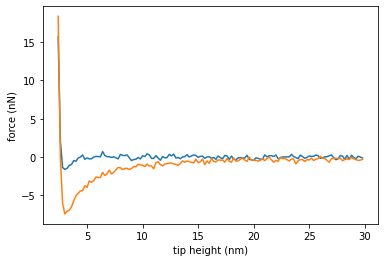

In [55]:
plt.plot(z,simulate_data_LJ(eps, sLJ, z))
plt.plot(z, simulate_data_M3(eps, sLJ, H,R,theta,z))


plt.xlabel('tip height (nm)')
plt.ylabel('force (nN)')

#need to cut the range otherwise you can't see the feature
#plt.ylim([-3,50]);

In [56]:
F_testdata = simulate_data_M3(eps, sLJ, H,R,theta,z)

### 4. Infer parameters from your simulated data.

Using pymc3

In [57]:
import pymc3 as pm
import arviz as az
import seaborn as sns

Step 1: define the model

In [58]:
M3_model = pm.Model()

with M3_model:
    
    #Jefferys prior from 0.0001 (10e-4) to 1000 e3
    logepsilon = pm.Uniform('logepsilon', -4, 3, testval = np.log(9))
    logsigma = pm.Uniform('logsigma',-4, 3, testval = np.log(2))
    
    #convert to reg parameters:
    epsilon = pm.Deterministic('epsilon', np.exp(logepsilon))
    sigma = pm.Deterministic('sigma', np.exp(logsigma))
    
    H = pm.HalfFlat('H', testval = 50)
    R = pm.Uniform('R', 5,50, testval = 25)
    theta = pm.Uniform('theta', 1,90, testval = 30)
    theta_rad = np.deg2rad(theta)
    #uniform prior
    #epsilon = pm.Uniform('epsilon', 0.01, 100, testval = 3) 
    #sigma = pm.Uniform('sigma', 0.01, 100, testval = 2)
    
    #model
    F = 4*epsilon*(12*sigma**12/z**13) - H/6*(R/z**2 
                                              + R*(1-np.sin(theta_rad))/(z*(z+R*(1-np.sin(theta_rad)))) 
                                              + np.tan(theta_rad)**2/(z+R*(1-np.sin(theta_rad))))
    
    # Likelihood of observations (i.e. noise around model)
    measurements = pm.Normal('F', mu=F, sigma=noise, observed=F_testdata)

Step 2: find the MAP (optional)

But I'm doing it to double check my starting guesses are good

In [59]:
map_estimate = pm.find_MAP(model = M3_model)
map_estimate

{'logepsilon_interval__': array(1.67417104),
 'logsigma_interval__': array(0.75147945),
 'H_log__': array(4.23509214),
 'R_interval__': array(-12.46972227),
 'theta_interval__': array(-0.60852697),
 'logepsilon': array(1.89491796),
 'logsigma': array(0.75650685),
 'epsilon': array(6.65200265),
 'sigma': array(2.13081993),
 'H': array(69.06804235),
 'R': array(5.00017285),
 'theta': array(32.36318074)}

Sample and plot samples:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logsigma, logepsilon]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.888116561392184, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8907889409390541, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


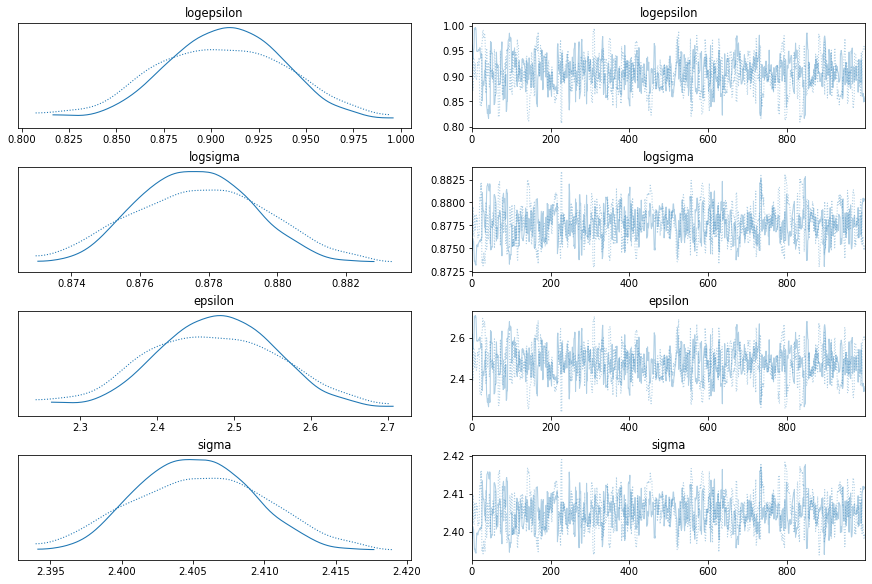

In [12]:
with LJ_model:
    trace =pm.sample(1000, start = map_estimate, return_inferencedata=True)
    az.plot_trace(trace);

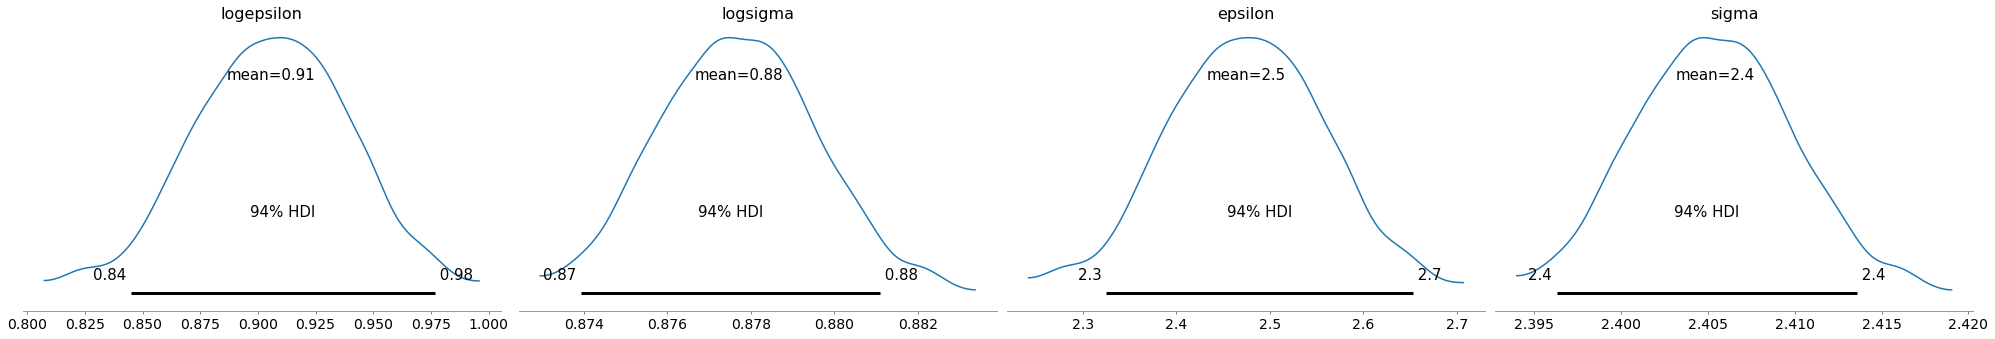

In [13]:
with LJ_model:
    az.plot_posterior(trace)

In [14]:
posterior_dataframe = trace.posterior.to_dataframe()

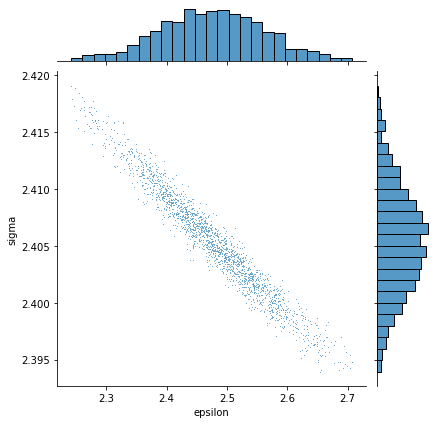

In [15]:
joint_kde = sns.jointplot(x='epsilon', y='sigma', data=posterior_dataframe, kind='scatter', s=1)

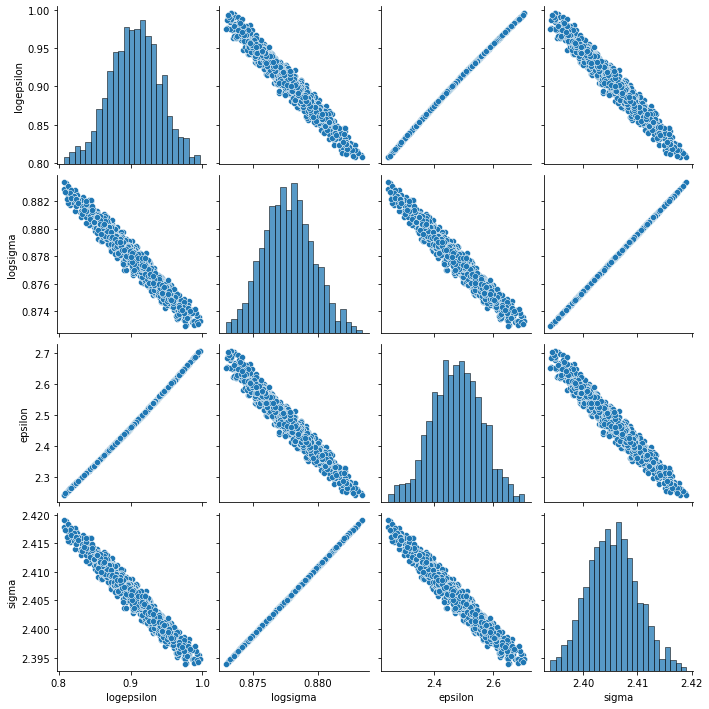

In [16]:
sns.pairplot(posterior_dataframe)

## Side quest: converting the error from $\sigma_\text{df}$ to $\sigma_\text{force}$

using the same z, let's trying to generate the df data, then use df+$\sigma_\text{df}$ in the Sader-Jarvis formula, then df-$\sigma_\text{df}$ in the formula to quantify $\sigma_\text{force}$. This will probably make $\sigma$ an array instead of a fixed value.

This is a really bad model (not really based on anything), but it's a good order of magntiude.

In [17]:
def simulate_df(B, C, z):
    
    z_new= z*10**-9
    perfect_data = 0.3*B**13/(z_new+5*10**-9)**13 - C/z_new**2
    
    return perfect_data/2*10**9

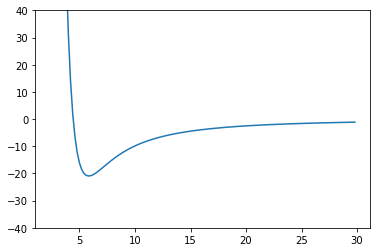

In [18]:
plt.plot(z, simulate_df(3*10**-9, 2*10**-24,z))
#plt.xlim([0, 25]);
plt.ylim([-40, 40]);